# 3. Data Prep for Machine Learning

In [1]:
import pandas as pd

In [2]:
# read in dataset

full_dat = pd.read_csv("fcac_data_for_ml.csv")

/Users/kaitlynlongo/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (15,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# filter to relevent features for machine learning
cols_to_keep = ['Species', 'Intake Type', 'Primary Breed','Gender', 'Primary Colour','Pre Altered',
                'Size','Condition', 'Age Group','is_mix', 'is_black','is_top_dog', 
                'is_multicolor', 'Group','Energy', 'Shedding','outcome_target']


# remove returns since they could bias the model
full_dat = full_dat[full_dat['Intake Type'] != 'Return']

full_dat_ml = full_dat.filter(items=cols_to_keep)

In [4]:
# remove everything besides adoption/return and euthanasia
full_dat_ml = full_dat_ml[full_dat_ml['outcome_target'] != 'DROP']
# All gender labeled unknown were euthanized, could introduce bias so drop these fields 
full_dat_ml = full_dat_ml[full_dat_ml['Gender'] != 'U']

In [5]:
# create separate datasets for dogs and cats
dog_full = full_dat_ml[full_dat_ml['Species'] == 'Dog']
cat_full = full_dat_ml[full_dat_ml['Species'] == 'Cat']

cat_full = cat_full.drop(columns=['Group', 'Species', 'is_top_dog'])
dog_full = dog_full.dropna(subset = ['Group'])
dog_full = dog_full.drop(columns=['Species'])

In [6]:
# create dummy variables for cat data
dummy_cols = ['Intake Type','Primary Breed','Gender', 'Primary Colour',
                'Size','Condition', 'Age Group','Pre Altered','Energy', 'Shedding']

cat_full_dummies = pd.get_dummies(cat_full, columns=dummy_cols, drop_first = True)

In [7]:
# create dummy variables for dog data
dummy_cols = ['Intake Type','Primary Breed','Gender', 'Primary Colour',
                'Size','Condition', 'Age Group','Group','Pre Altered','Energy', 'Shedding']

dog_full_dummies = pd.get_dummies(dog_full, columns=dummy_cols, drop_first = True)

In [8]:
cat_full['outcome_target'].describe()

count          15757
unique             2
top       Euthanasia
freq            9807
Name: outcome_target, dtype: object

In [9]:
dog_full['outcome_target'].describe()

count        8928
unique          2
top       Success
freq         6510
Name: outcome_target, dtype: object

# 4. Machine Learning

## Predicting the Outcome

In [35]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, accuracy_score, f1_score
from sklearn.svm import SVC
import numpy as np
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc

In [16]:
# start with cats

## Cats

In [113]:
# Extract the labels

cat_no_label = cat_full_dummies
cat_no_label = cat_no_label.drop(columns=['outcome_target'])

labels_str = np.array(cat_full['outcome_target'])

le = preprocessing.LabelEncoder()
labels = np.array(le.fit_transform(labels_str))


# split data into test and train
train, test, train_labels, test_labels = train_test_split(cat_no_label,
                                         labels, 
                                         stratify = labels,
                                         test_size = 0.4, 
                                         random_state = 30)

In [114]:
le.classes_

array(['Euthanasia', 'Success'], dtype=object)

### Random Forest (cats)

In [64]:
# Create the parameter grid based on the results of random search 
f1score = make_scorer(f1_score,average = 'macro')

# parameters to try
param_grid = {
    'max_depth': [10, 20, 30, 40],
    'max_features': [5, 10, 20],
    'n_estimators': [100, 200, 300, 1000]
}

# create RD model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring = f1score)

# fit model
grid_search.fit(train,train_labels)
grid_search.best_params_

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  2.2min finished


{'max_depth': 10, 'max_features': 20, 'n_estimators': 100}

In [65]:
# print best F1 score from cross validation
np.mean(grid_search.cv_results_['mean_test_score'])
grid_search.best_score_

0.7304248281937923

In [66]:
# fit using optimal parameters
rfc = RandomForestClassifier(max_depth= 10,max_features= 20, n_estimators=100)
rfc.fit(train,train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features=20,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Text(0.5, 0, 'False Positive Rate')

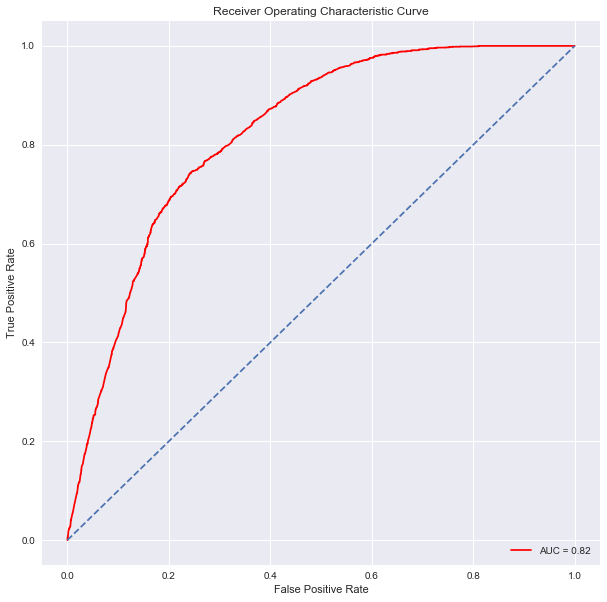

In [67]:
# Plot ROC curve
y_prob = rfc.predict_proba(test)[:,1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic Curve')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [68]:
# apply to test data 
print("=== Confusion Matrix ===")
print(confusion_matrix(test_labels, rfc.predict(test)))
print('\n')
print("=== Classification Report ===")
print(classification_report(test_labels, rfc.predict(test)))
print("=== Accuracy ===")
print(accuracy_score(test_labels, rfc.predict(test)))
print('\n')

print("=== F1 ===")
print(f1_score(test_labels, rfc.predict(test),average='weighted'))
print('\n')

=== Confusion Matrix ===
[[3274  649]
 [ 879 1501]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.79      0.83      0.81      3923
           1       0.70      0.63      0.66      2380

    accuracy                           0.76      6303
   macro avg       0.74      0.73      0.74      6303
weighted avg       0.75      0.76      0.75      6303

=== Accuracy ===
0.7575757575757576


=== F1 ===
0.754873553737984




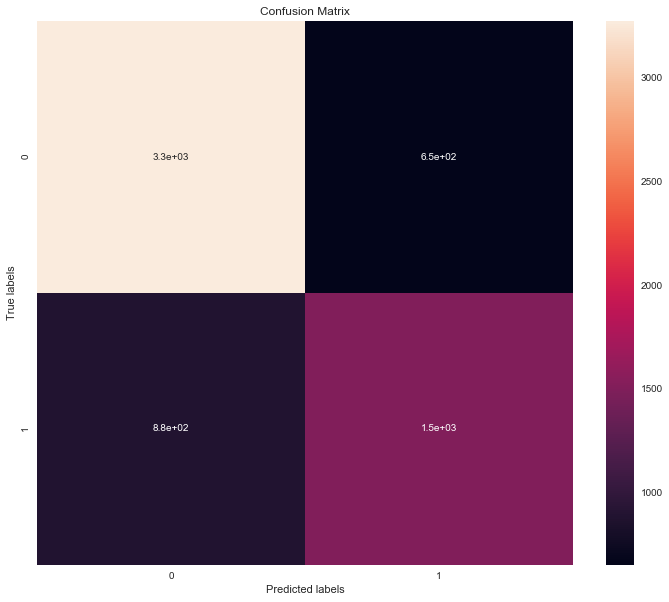

In [70]:
# plot confusion matrix
cm = confusion_matrix(test_labels, rfc.predict(test))

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

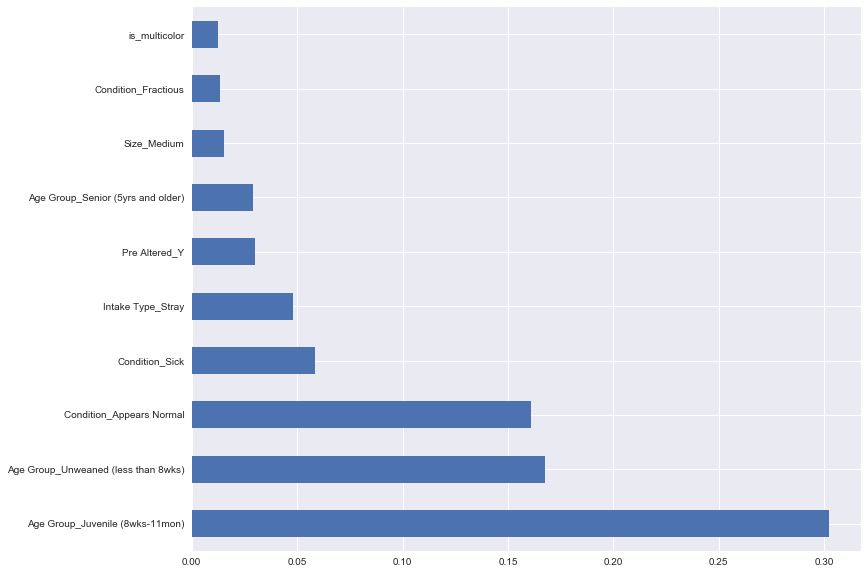

In [46]:
# plot feature importances
feat_importances = pd.Series(rfc.feature_importances_, index=cat_no_label.columns)
feat_importances.nlargest(10).plot(kind='barh')

### XGBoost (cats)

In [82]:
# define parameters to try
gbm_param_grid = {'eta': [0.02],
              'objective':['binary:logistic'],
              'learning_rate': [.01, 0.05, .1],
              'max_depth': [5,10,20],
              'silent': [1],
              'colsample_bytree': [0.7],
              'n_estimators': [5,50,100,1000], 
              'seed': [50],
                'nthread':[4]}

# Instantiate classifier
gbm = xgb.XGBRFClassifier()

# Perform grid search
grid_cv_xgb = GridSearchCV(estimator=gbm, param_grid=gbm_param_grid,
                        scoring=f1score, cv=3, verbose=1)
grid_cv_xgb.fit(train, train_labels)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  7.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBRFClassifier(base_score=0.5, colsample_bylevel=1,
                                       colsample_bynode=0.8, colsample_bytree=1,
                                       gamma=0, learning_rate=1,
                                       max_delta_step=0, max_depth=3,
                                       min_child_weight=1, missing=None,
                                       n_estimators=100, n_jobs=1, nthread=None,
                                       objective='binary:logistic',
                                       random_state=0, reg_alpha=0,
                                       reg_lambda=1, scale_pos_weight=1,
                                       seed...
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.7], 'eta': [0.02],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [5, 10, 20],
                         'n_estimators'

In [84]:
# Print the best parameters and score
print(grid_cv_xgb.best_score_)
print(grid_cv_xgb.best_params_)

0.7280193337957547
{'colsample_bytree': 0.7, 'eta': 0.02, 'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 100, 'nthread': 4, 'objective': 'binary:logistic', 'seed': 50, 'silent': 1}


In [85]:
# fit with optimal parameters to train and apply to test
D_train = xgb.DMatrix(train, label=train_labels)
D_test = xgb.DMatrix(test, label=test_labels)

param = {'eta': 0.02,
              'objective':'binary:logistic',
              'learning_rate': 0.01,
              'max_depth': 20,
              'silent': 1,
              'colsample_bytree': 0.7,
              'n_estimators': 100, 
              'seed': 50,
                'nthread':4}

steps = 20  # The number of training iterations

model = xgb.train(param, D_train, steps)

preds = model.predict(D_test)
binary_preds = np.where(preds > 0.5, 1, 0)

In [86]:
# get metrics
print("=== Confusion Matrix ===")
print(confusion_matrix(test_labels, binary_preds))
print('\n')
print("=== Classification Report ===")
print(classification_report(test_labels, binary_preds))
print("=== Accuracy ===")
print(accuracy_score(test_labels, binary_preds))
print('\n')

print("=== F1 ===")
print(f1_score(test_labels, binary_preds,average='weighted'))
print('\n')

=== Confusion Matrix ===
[[3242  681]
 [ 862 1518]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.79      0.83      0.81      3923
           1       0.69      0.64      0.66      2380

    accuracy                           0.76      6303
   macro avg       0.74      0.73      0.74      6303
weighted avg       0.75      0.76      0.75      6303

=== Accuracy ===
0.7551959384420117


=== F1 ===
0.7531176273819137




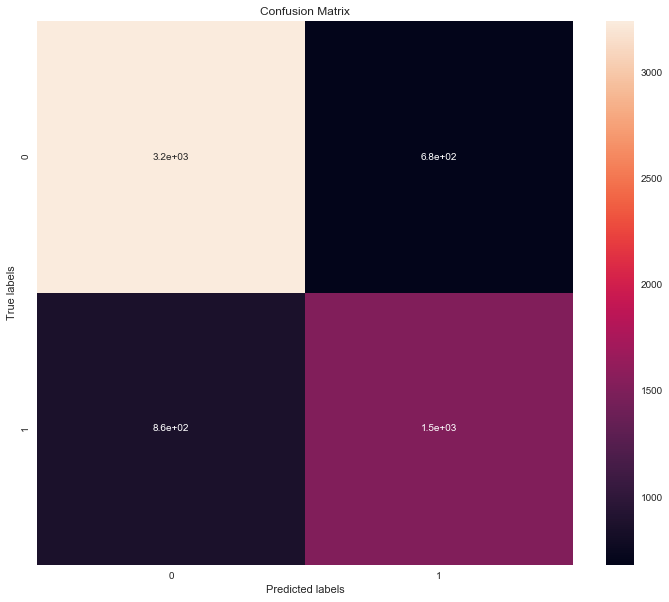

In [88]:
# confusion matrix
cm = confusion_matrix(test_labels, binary_preds)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

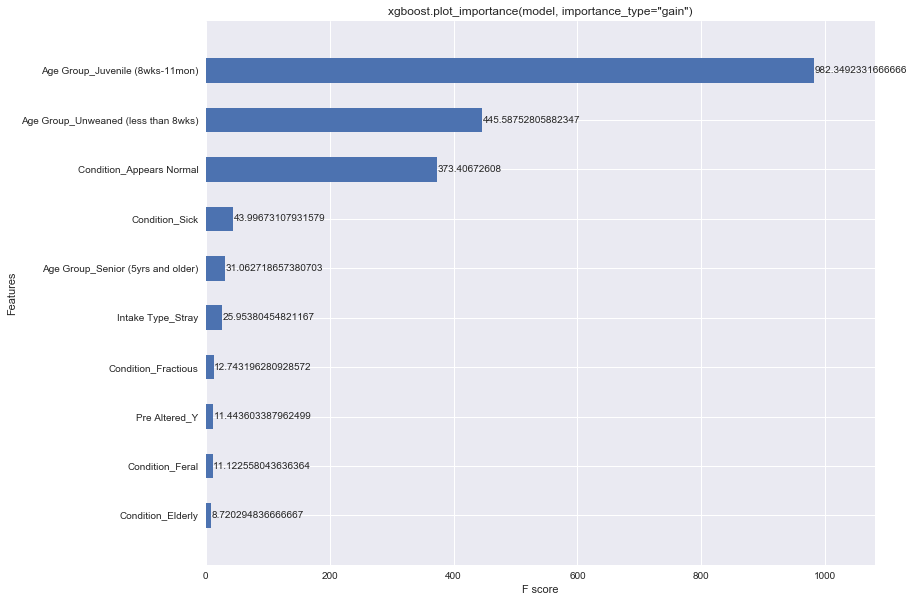

In [99]:
# feature imporance plot
xgb.plot_importance(model, importance_type="gain",max_num_features=10, height = .5)
plt.title('xgboost.plot_importance(model, importance_type="gain")')
plt.show()

Text(0.5, 0, 'False Positive Rate')

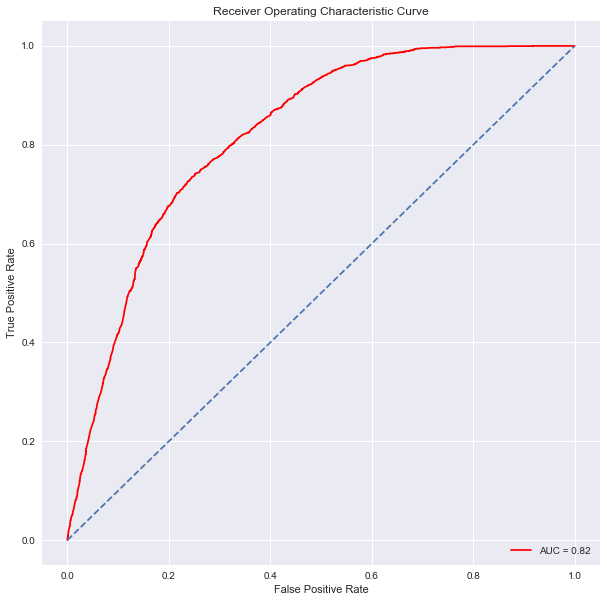

In [103]:
# ROC Curve
y_prob = preds

false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic Curve')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

### Logistic Regression with Lasso (cats)

In [115]:
from sklearn.linear_model import LogisticRegression

# l1 is lasso regularization

log = LogisticRegression(penalty='l1',random_state=30,solver = 'liblinear')
log.fit(train,train_labels)

log_predict = log.predict(test)

In [116]:
scorer = sklearn.metrics.make_scorer(sklearn.metrics.f1_score, average = 'macro')

log_cv_score = cross_val_score(log, train, train_labels, cv=5, scoring=scorer)

print("=== Confusion Matrix ===")
print(confusion_matrix(test_labels, log_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(test_labels, log_predict))
print('\n')
print("=== All F1 Scores ===")
print(log_cv_score)
print('\n')
print("=== Mean F1 Score ===")
print("Mean F1 Score - Logistic Regression: ", log_cv_score.mean())

=== Confusion Matrix ===
[[3220  703]
 [ 902 1478]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.78      0.82      0.80      3923
           1       0.68      0.62      0.65      2380

    accuracy                           0.75      6303
   macro avg       0.73      0.72      0.72      6303
weighted avg       0.74      0.75      0.74      6303



=== All F1 Scores ===
[0.7116963  0.73479185 0.73366848 0.71493608 0.7137567 ]


=== Mean F1 Score ===
Mean F1 Score - Logistic Regression:  0.7217698823597336


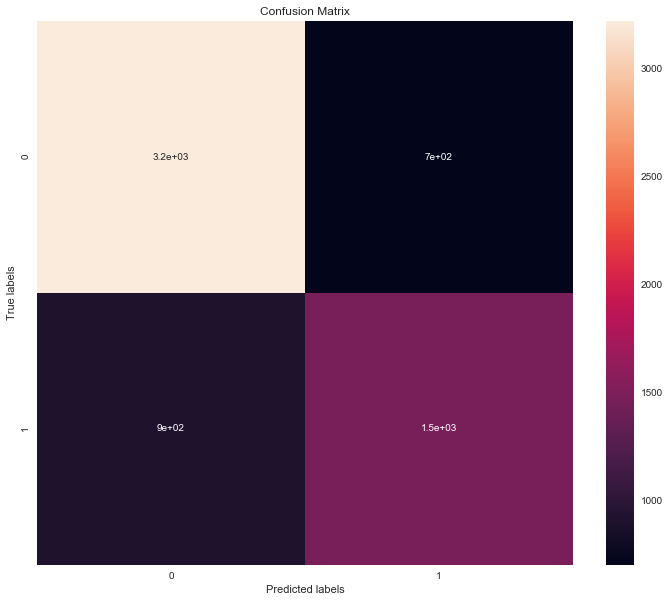

In [123]:
cm = confusion_matrix(test_labels, log_predict)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

Text(0.5, 0, 'False Positive Rate')

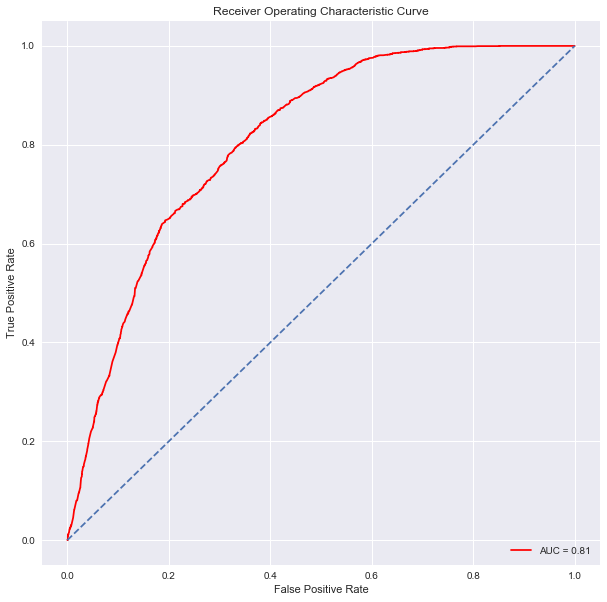

In [124]:
y_prob = log.predict_proba(test)[:,1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic Curve')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

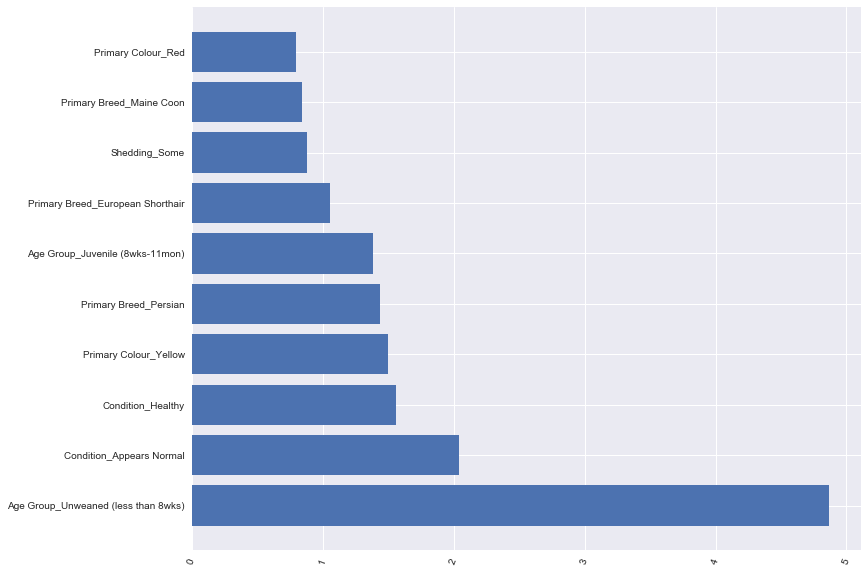

In [122]:
# plot features based on absolute value of coefficients
log_features = pd.DataFrame(log.coef_[0],train.columns,columns=["Features"]).sort_values(by = 'Features', ascending=False)
log_features['Features'] = np.abs(log_features['Features'])

log_features = log_features.sort_values(by='Features',ascending=False)[:10]
plt.barh(log_features.index, log_features['Features']);
plt.xticks(rotation=70);

### Dogs

In [125]:
# Extract the labels

dog_no_label = dog_full_dummies
dog_no_label = dog_no_label.drop(columns=['outcome_target'])

labels_str = np.array(dog_full['outcome_target'])

le = preprocessing.LabelEncoder()
labels = np.array(le.fit_transform(labels_str))

# split into test and train
train, test, train_labels, test_labels = train_test_split(dog_no_label,
                                         labels, 
                                         stratify = labels,
                                         test_size = 0.3, 
                                         random_state = 30)

In [105]:
le.classes_

array(['Euthanasia', 'Success'], dtype=object)

### Random Forest (dogs)

In [73]:
# Create the parameter grid based on the results of random search 
f1score = make_scorer(f1_score,average = 'macro')

# define parameters
param_grid = {
    'max_depth': [10, 20, 30, 40],
    'max_features': [5, 10, 20],
    'n_estimators': [100, 200, 300, 1000]
}
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring = f1score)

grid_search.fit(train,train_labels)

grid_search.best_params_

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  2.3min finished


{'max_depth': 20, 'max_features': 20, 'n_estimators': 1000}

In [74]:
# average F1 score
np.mean(grid_search.cv_results_['mean_test_score'])
grid_search.best_score_

0.7609226458802937

In [75]:
# fit to train data
rfc = RandomForestClassifier(max_depth= 20,max_features= 20, n_estimators=1000)
rfc.fit(train,train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features=20,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Text(0.5, 0, 'False Positive Rate')

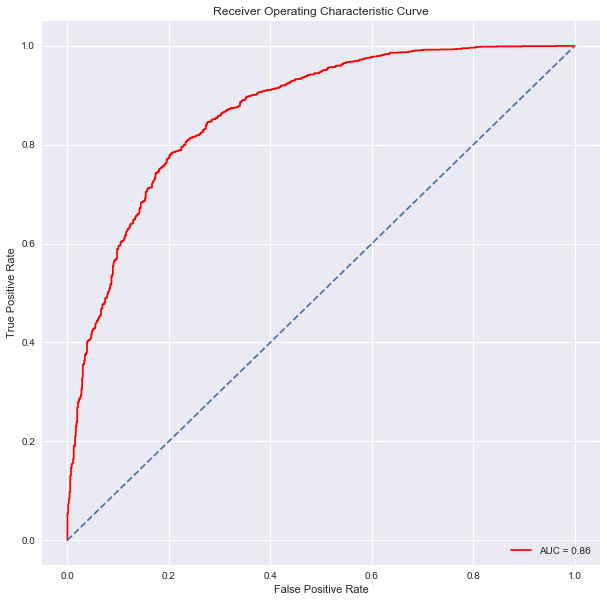

In [76]:
# ROC Curve
y_prob = rfc.predict_proba(test)[:,1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic Curve')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [77]:
print("=== Confusion Matrix ===")
print(confusion_matrix(test_labels, rfc.predict(test)))
print('\n')
print("=== Classification Report ===")
print(classification_report(test_labels, rfc.predict(test)))
print("=== Accuracy ===")
print(accuracy_score(test_labels, rfc.predict(test)))
print('\n')

print("=== F1 ===")
print(f1_score(test_labels, rfc.predict(test),average='weighted'))
print('\n')

=== Confusion Matrix ===
[[ 406  320]
 [ 141 1812]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.74      0.56      0.64       726
           1       0.85      0.93      0.89      1953

    accuracy                           0.83      2679
   macro avg       0.80      0.74      0.76      2679
weighted avg       0.82      0.83      0.82      2679

=== Accuracy ===
0.8279208659947742


=== F1 ===
0.8195927627812218




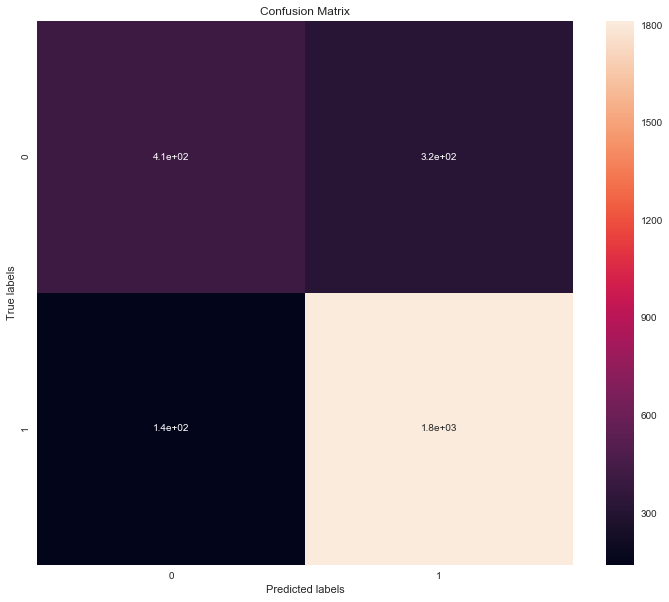

In [78]:
cm = confusion_matrix(test_labels, rfc.predict(test))

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

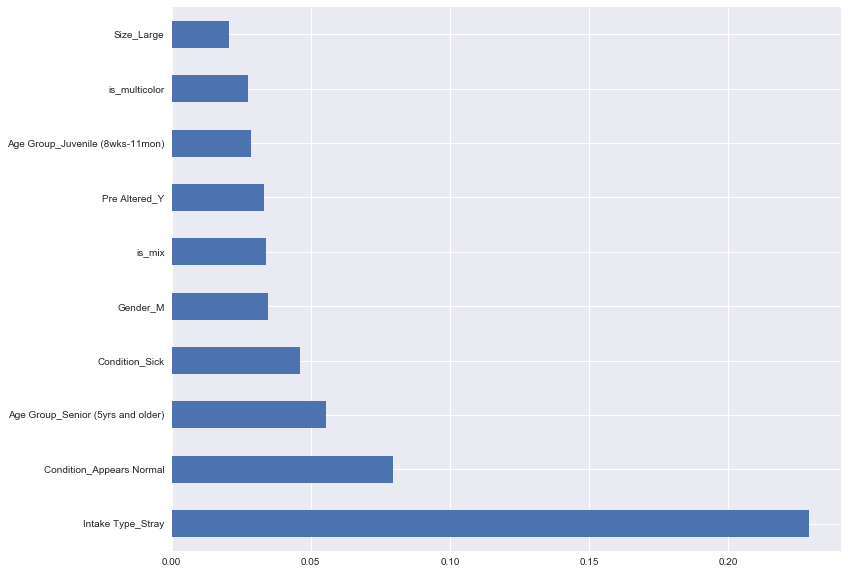

In [79]:
feat_importances = pd.Series(rfc.feature_importances_, index=dog_no_label.columns)
feat_importances.nlargest(10).plot(kind='barh')

### XGBoost (dogs)

In [106]:
# define parameters
gbm_param_grid = {'eta': [0.02],
              'objective':['binary:logistic'],
              'learning_rate': [.01, 0.05, .1],
              'max_depth': [5,10,20],
              'silent': [1],
              'colsample_bytree': [0.7],
              'n_estimators': [5,50,100,1000], 
              'seed': [50],
                'nthread':[4]}

# Instantiate the regressor: gbm
gbm = xgb.XGBRFClassifier()

# Perform grid search: grid_mse
grid_cv_xgb = GridSearchCV(estimator=gbm, param_grid=gbm_param_grid,
                        scoring=f1score, cv=3, verbose=1)
grid_cv_xgb.fit(train, train_labels)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed: 10.1min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBRFClassifier(base_score=0.5, colsample_bylevel=1,
                                       colsample_bynode=0.8, colsample_bytree=1,
                                       gamma=0, learning_rate=1,
                                       max_delta_step=0, max_depth=3,
                                       min_child_weight=1, missing=None,
                                       n_estimators=100, n_jobs=1, nthread=None,
                                       objective='binary:logistic',
                                       random_state=0, reg_alpha=0,
                                       reg_lambda=1, scale_pos_weight=1,
                                       seed...
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.7], 'eta': [0.02],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [5, 10, 20],
                         'n_estimators'

In [107]:
# Print the best parameters and score
print(grid_cv_xgb.best_score_)
print(grid_cv_xgb.best_params_)

0.7580881153465576
{'colsample_bytree': 0.7, 'eta': 0.02, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 50, 'nthread': 4, 'objective': 'binary:logistic', 'seed': 50, 'silent': 1}


In [108]:
D_train = xgb.DMatrix(train, label=train_labels)
D_test = xgb.DMatrix(test, label=test_labels)

param = {'eta': 0.02,
              'objective':'binary:logistic',
              'learning_rate': 0.01,
              'max_depth': 10,
              'silent': 1,
              'colsample_bytree': 0.7,
              'n_estimators': 50, 
              'seed': 50,
                'nthread':4}

steps = 20  # The number of training iterations

model = xgb.train(param, D_train, steps)

preds = model.predict(D_test)
binary_preds = np.where(preds > 0.5, 1, 0)

In [109]:
print("=== Confusion Matrix ===")
print(confusion_matrix(test_labels, binary_preds))
print('\n')
print("=== Classification Report ===")
print(classification_report(test_labels, binary_preds))
print("=== Accuracy ===")
print(accuracy_score(test_labels, binary_preds))
print('\n')

print("=== F1 ===")
print(f1_score(test_labels, binary_preds,average='weighted'))
print('\n')

=== Confusion Matrix ===
[[ 361  365]
 [  93 1860]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.80      0.50      0.61       726
           1       0.84      0.95      0.89      1953

    accuracy                           0.83      2679
   macro avg       0.82      0.72      0.75      2679
weighted avg       0.82      0.83      0.81      2679

=== Accuracy ===
0.8290406868234416


=== F1 ===
0.8149018768253783




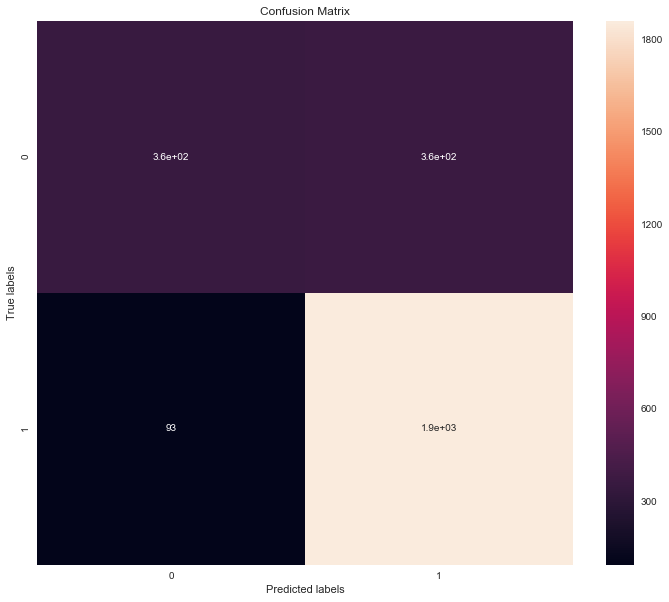

In [110]:
cm = confusion_matrix(test_labels, binary_preds)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

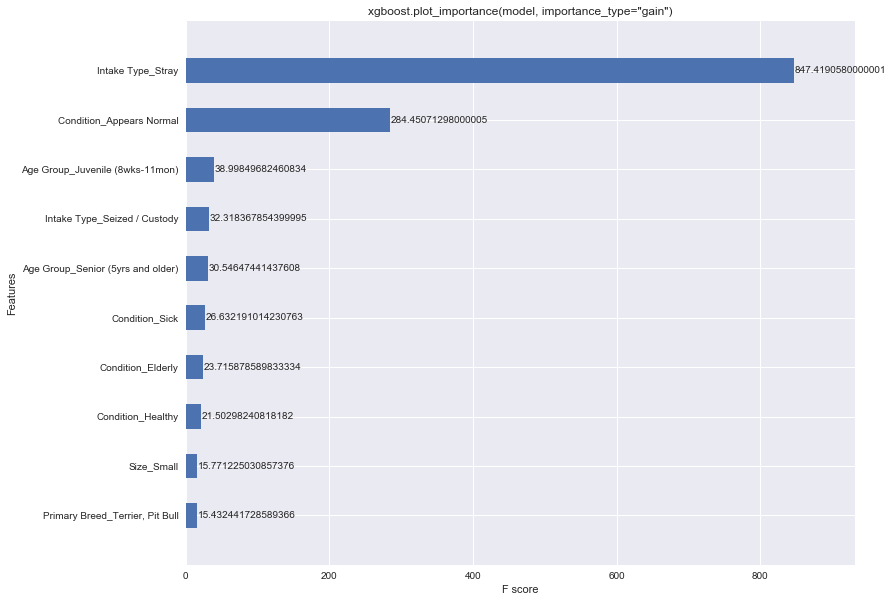

In [111]:
xgb.plot_importance(model, importance_type="gain",max_num_features=10, height = .5)
plt.title('xgboost.plot_importance(model, importance_type="gain")')
plt.show()

Text(0.5, 0, 'False Positive Rate')

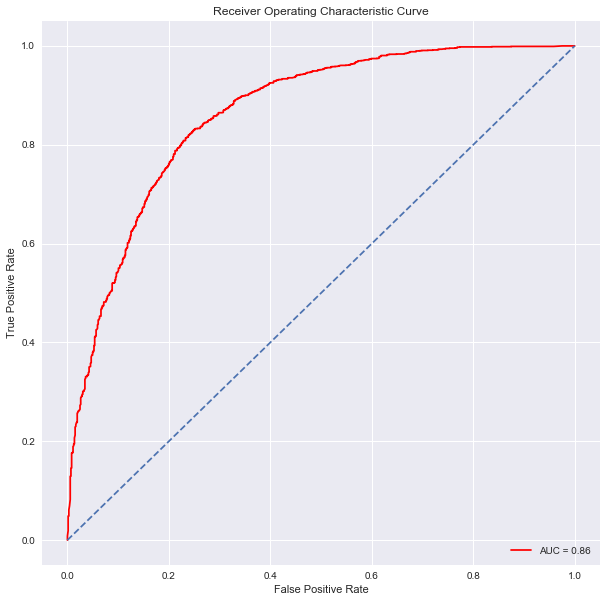

In [112]:
y_prob = preds

false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic Curve')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

### Logistic Regression with lasso (dogs)

In [126]:
from sklearn.linear_model import LogisticRegression
# l1 = lasso

log = LogisticRegression(penalty='l1',random_state=30,solver = 'liblinear')
log.fit(train,train_labels)

log_predict = log.predict(test)

In [127]:
scorer = sklearn.metrics.make_scorer(sklearn.metrics.f1_score, average = 'macro')

log_cv_score = cross_val_score(log, train, train_labels, cv=5, scoring=scorer)

print("=== Confusion Matrix ===")
print(confusion_matrix(test_labels, log_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(test_labels, log_predict))
print('\n')
print("=== All F1 Scores ===")
print(log_cv_score)
print('\n')
print("=== Mean F1 Score ===")
print("Mean F1 Score - Logistic Regression: ", log_cv_score.mean())

=== Confusion Matrix ===
[[ 420  306]
 [ 153 1800]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.73      0.58      0.65       726
           1       0.85      0.92      0.89      1953

    accuracy                           0.83      2679
   macro avg       0.79      0.75      0.77      2679
weighted avg       0.82      0.83      0.82      2679



=== All F1 Scores ===
[0.79307593 0.76430103 0.77496248 0.78354978 0.78152583]


=== Mean F1 Score ===
Mean F1 Score - Logistic Regression:  0.7794830120219018


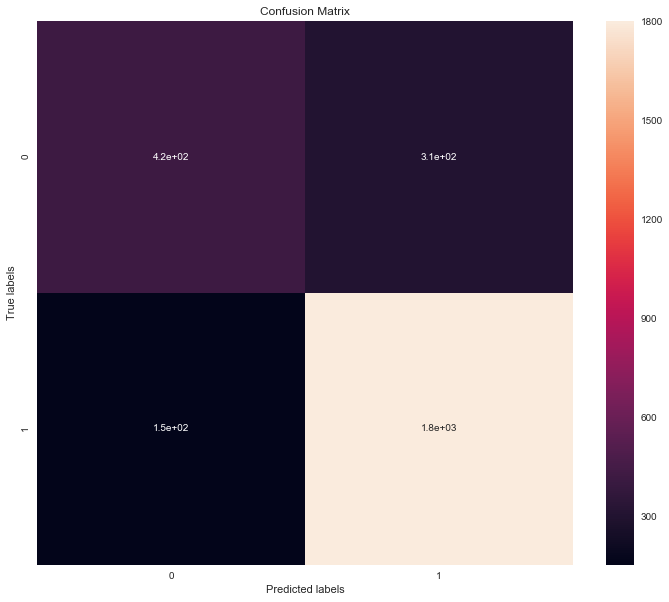

In [131]:
cm = confusion_matrix(test_labels, log_predict)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

Text(0.5, 0, 'False Positive Rate')

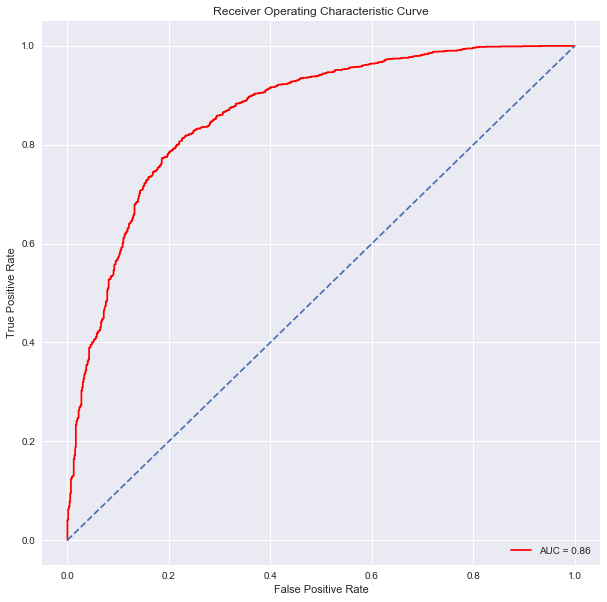

In [128]:
y_prob = log.predict_proba(test)[:,1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic Curve')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

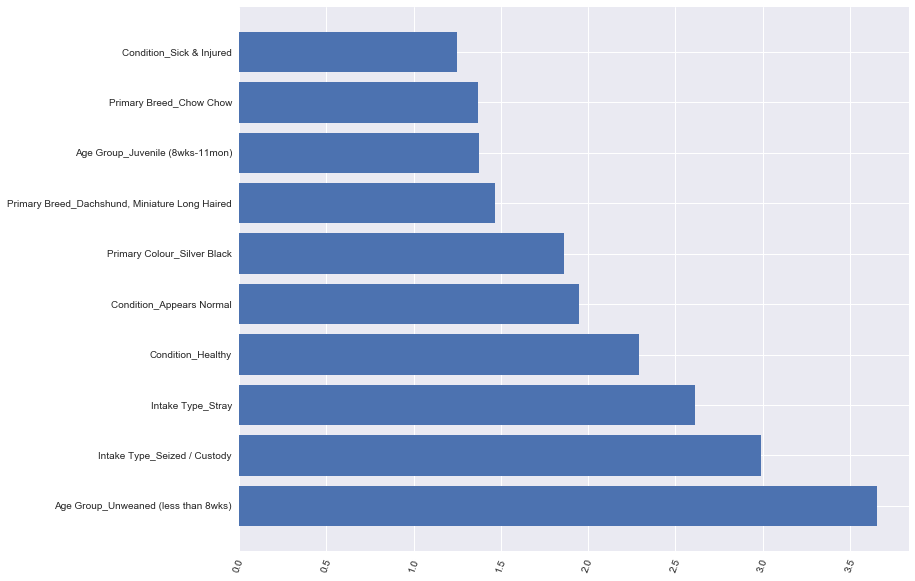

In [130]:
log_features = pd.DataFrame(log.coef_[0],train.columns,columns=["Features"]).sort_values(by = 'Features', ascending=False)
log_features['Features'] = np.abs(log_features['Features'])

log_features = log_features.sort_values(by='Features',ascending=False)[:10]
plt.barh(log_features.index, log_features['Features']);
plt.xticks(rotation=70);